# Import Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch

In [24]:
! git clone https://github.com/udacity/P1_Facial_Keypoints.git

fatal: destination path 'P1_Facial_Keypoints' already exists and is not an empty directory.


In [25]:
!ls
!pwd

P1_Facial_Keypoints  sample_data
/content


In [26]:
key_pts_frame = pd.read_csv("./P1_Facial_Keypoints/data/training_frames_keypoints.csv")
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n,1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)
print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

print('Image Name',   image_name)
print('Landmarks shape:',key_pts.shape[0])
print("first 4 key: {}".format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]
Image Name Luis_Fonsi_21.jpg
Landmarks shape: 68
first 4 key: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [27]:
# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


# Show some images

In [28]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:,0],key_pts[:,1], s=20, marker=".", c="m")

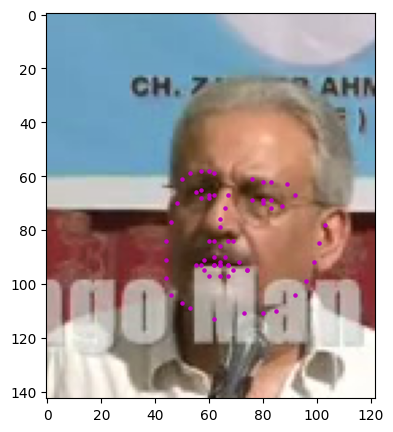

(143, 122, 4)


In [29]:
n = 222
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n,1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)
plt.figure(figsize=(5,5))
img = mpimg.imread(os.path.join("./P1_Facial_Keypoints/data/training/", image_name))
show_keypoints(img, key_pts)
plt.show()
print(img.shape)


## dataset loader and transformation

In [30]:
class FacialKeypointsDataset(Dataset):
    """Face Keypoints Dataset."""

    def __init__(self, csv_file, root_dir, transformation = None, train = True):
      """
      Args:
      csv_file (string): path to csv file with annotations
      root_dir (string): directory with all images
      transformation (callable, optional):  Optional transform to be applied
                                            on a sample.
      """
      self.key_pts_frame = pd.read_csv(csv_file)
      if train == True:
        self.root_dir = os.path.join(root_dir,"training/")
      else:
        self.root_dir = os.path.join(root_dir,"test/")
      self.transformation = transformation

    def __len__(self):
      return len(self.key_pts_frame)

    def __getitem__(self, idx):
      image_path = os.path.join(self.root_dir, self.key_pts_frame.iloc[idx, 0])
      image = mpimg.imread(image_path)

      # if image has an alpha color channel, delete it
      if(image.shape[2] == 4):
            image = image[:,:,0:3]
      key_pts = self.key_pts_frame.iloc[idx, 1:].values
      key_pts = key_pts.astype('float').reshape(-1, 2)
      sample = {'image': image, 'keypoints': key_pts}
      if self.transformation:
            sample = self.transformation(sample)
      return sample



In [31]:
face_dataset = FacialKeypointsDataset(csv_file='./P1_Facial_Keypoints/data/training_frames_keypoints.csv',
                                    root_dir='./P1_Facial_Keypoints/data')
print("length of dataset =", len(face_dataset))

length of dataset = 3462


0 (147, 120, 3) (68, 2)
1 (108, 85, 3) (68, 2)
2 (320, 314, 3) (68, 2)
3 (203, 196, 3) (68, 2)
4 (153, 148, 3) (68, 2)


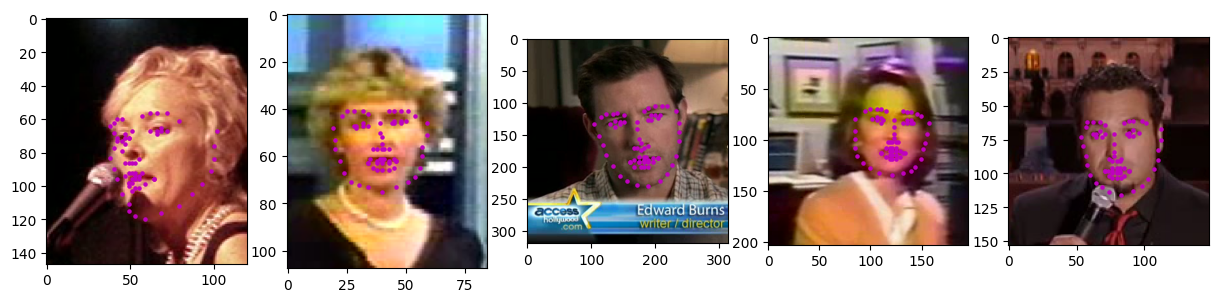

In [32]:
fig = plt.figure(figsize = (15,5))
num_disp = 5
for i in range(num_disp):
  rand_idx = np.random.randint(0,len(face_dataset))
  sample = face_dataset[rand_idx]
  print(i, sample['image'].shape, sample['keypoints'].shape)
  fig.add_subplot(1,num_disp,i+1)
  show_keypoints(sample['image'], sample['keypoints'])

## Transforms
* normalization
* rescale
* random crop
* ToTensor

In [39]:
# normalization
class Normalize(object):
  """Convert a color image to grayscale and normalize the color range to [0,1]."""

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']
    # scale keypoints to be centered around 0 with a range of [-1, 1]
    # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50

    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image/255.0
    key_pts = (key_pts - 100)/50.0
    return {'image': image, 'keypoints': key_pts}

# rescale

class Rescale(object):
  """Rescale the image in a sample to a given size.
  Args:
    output_size (tuple or int): Desired output size. If tuple, output is
    matched to output_size. If int, smaller of image edges is matched
    to output_size keeping aspect ratio the same.
  """
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']
    h, w = image.shape[:2]
    if isinstance(self.output_size, int):
      if h > w:
        new_h, new_w = self.output_size * h / w, self.output_size
      else:
        new_h, new_w = self.output_size , self.output_size * w / h
    else:
      new_h, new_w = self.output_size
    new_h, new_w = int(new_h), int(new_w)
    image = cv2.resize(image , (new_h, new_w))
    key_pts = key_pts * [new_w/w, new_h/h]
    return {'image': image, 'keypoints': key_pts}

class RandomCrop(object):
  """ implement random crop in a sample
  Args:
      output_size (tuple or int): Desired output size. If int, square crop
      is made.
  """
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
      self.output_size = (output_size, output_size)
    else:
      assert len(output_size) == 2 # check if there are w and h in output_size var
      self.output_size = output_size
  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']
    h, w = image.shape[:2]
    new_h, new_w = self.output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top:top+new_h, left:left+new_w]
    key_pts = key_pts - [left, top]

    return {'image': image, 'keypoints': key_pts}

class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""
  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']

    # if image has no grayscale color channel, add one
    if(len(image.shape) == 2):
      # add that third color dim
      image = image.reshape(image.shape[0], image.shape[1], 1)

    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    image = image.transpose((2, 0, 1))

    return {'image': torch.from_numpy(image),
            'keypoints': torch.from_numpy(key_pts)}



## test transformation

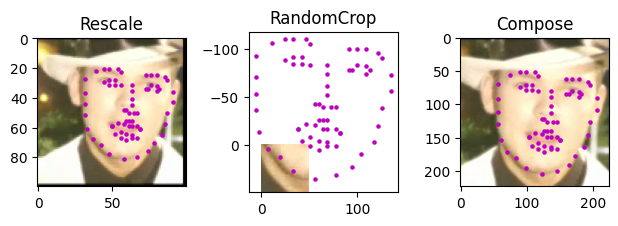

In [40]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 200
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [45]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./P1_Facial_Keypoints/data/training_frames_keypoints.csv',
                                          root_dir='./P1_Facial_Keypoints/data/',
                                             transformation=data_transform)

# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])
